## Variant 1 (Fear Greed)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Data Collection

In [44]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv("../Data/tickers.csv")

closing_prices = data["Adj Close"]
returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_prices, market_caps

closing_prices.tail(10)

[*********************100%***********************]  7 of 7 completed


Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15 00:00:00+00:00,139.149994,149.970001,45.549957,333.645508,48.876141,22.830000,253.500000
2023-12-18 00:00:00+00:00,138.899994,154.070007,45.086163,343.308563,50.062805,23.799999,252.080002
2023-12-19 00:00:00+00:00,140.149994,153.789993,46.043350,349.026733,49.589939,24.350000,257.220001
2023-12-20 00:00:00+00:00,135.470001,152.119995,45.155243,347.950867,48.097359,23.180000,247.139999
2023-12-21 00:00:00+00:00,139.910004,153.839996,46.457802,352.742554,48.976116,23.580000,254.500000
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.045197,48.816162,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.479706,49.265030,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089161,356.468323,49.402992,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724056,356.956451,49.507965,23.540001,253.179993


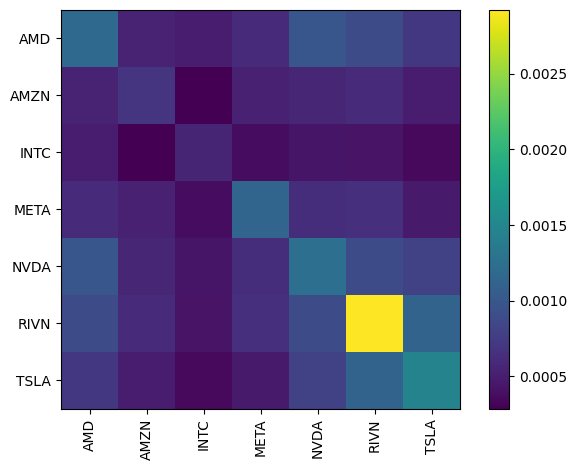

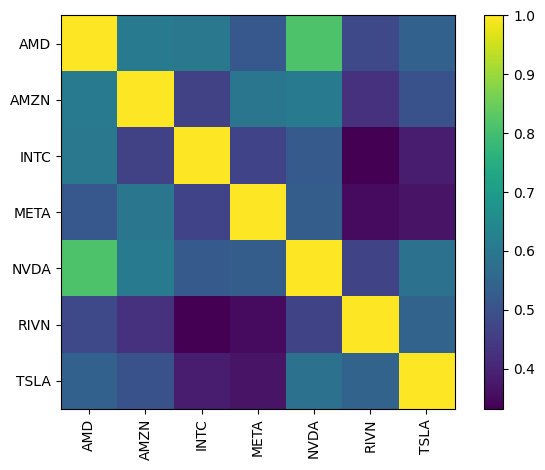

In [10]:
covariance_matrix = returns.cov()
covariance_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(covariance_matrix, plot_correlation=True)

In [11]:
covariance_matrix

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Ticker,,,,,,,
AMD,0.001181,0.000547,0.000489,0.000602,0.000990,0.000892,0.000709
AMZN,0.000547,0.000687,0.000286,0.000529,0.000567,0.000604,0.000501
INTC,0.000489,0.000286,0.000563,0.000376,0.000436,0.000425,0.000348
META,0.000602,0.000529,0.000376,0.001150,0.000633,0.000644,0.000476
NVDA,0.000990,0.000567,0.000436,0.000633,0.001252,0.000897,0.000791
RIVN,0.000892,0.000604,0.000425,0.000644,0.000897,0.002920,0.001124
TSLA,0.000709,0.000501,0.000348,0.000476,0.000791,0.001124,0.001462


### Get Prior and Delta

In [30]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, fg_covariance_matrix)

market_caps
market_prices

[*********************100%***********************]  1 of 1 completed


Date
2013-01-02    108.388939
2013-01-03    108.291588
2013-01-04    108.745888
2013-01-07    108.453865
2013-01-08    108.129311
                 ...    
2023-12-22    431.015503
2023-12-26    432.807709
2023-12-27    433.599823
2023-12-28    433.669159
2023-12-29    432.510620
Name: Adj Close, Length: 2768, dtype: float64

### Get Individual Fear-Greed Score

In [54]:
def get_fear_greed(tickers, start_date=start_date, end_date=end_date):
    fear_greed_scores_dict = {}

    for ticker in tickers:
        try:
            # calculate each indicator for the stock
            rsi = calculate_stock_rsi([ticker], start_date=start_date, end_date=end_date)[ticker].iloc[-1]['RSI']
            price_strength, high, low, current_price = calculate_stock_price_strength([ticker])
            breadth_data = calculate_stock_price_breadth([ticker], start=start_date, end=end_date)
            volatility = calculate_market_volatility([ticker], start_date=start_date, end_date=end_date)[ticker]
            put_call_ratio = calculate_put_call_ratio([ticker])[ticker]

            # normalise each indicator (as rsi is from 0-100 etc)
            normalised_rsi = rsi / 100
            normalised_price_strength = price_strength
            latest_breadth_ratio = breadth_data['breadth_ratio'].iloc[-1]
            normalised_breadth = min(max(latest_breadth_ratio / 2, 0), 1)
            normalised_volatility = min(max(volatility / 100, 0), 1)
            normalised_put_call_ratio = min(max(put_call_ratio, 0), 1) if put_call_ratio is not None else 0.5

            rsi_weight = 0.2 #  equal weights
            price_strength_weight = 0.2
            breadth_weight = 0.2
            volatility_weight = 0.2
            put_call_ratio_weight = 0.2

            # calculate the FG score
            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight +
                normalised_volatility * volatility_weight +
                normalised_put_call_ratio * put_call_ratio_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error has occurred for {ticker}: {error} when attempting to calculate the fear-greed score")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

#### Calculate Relative Strength Index (RSI)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


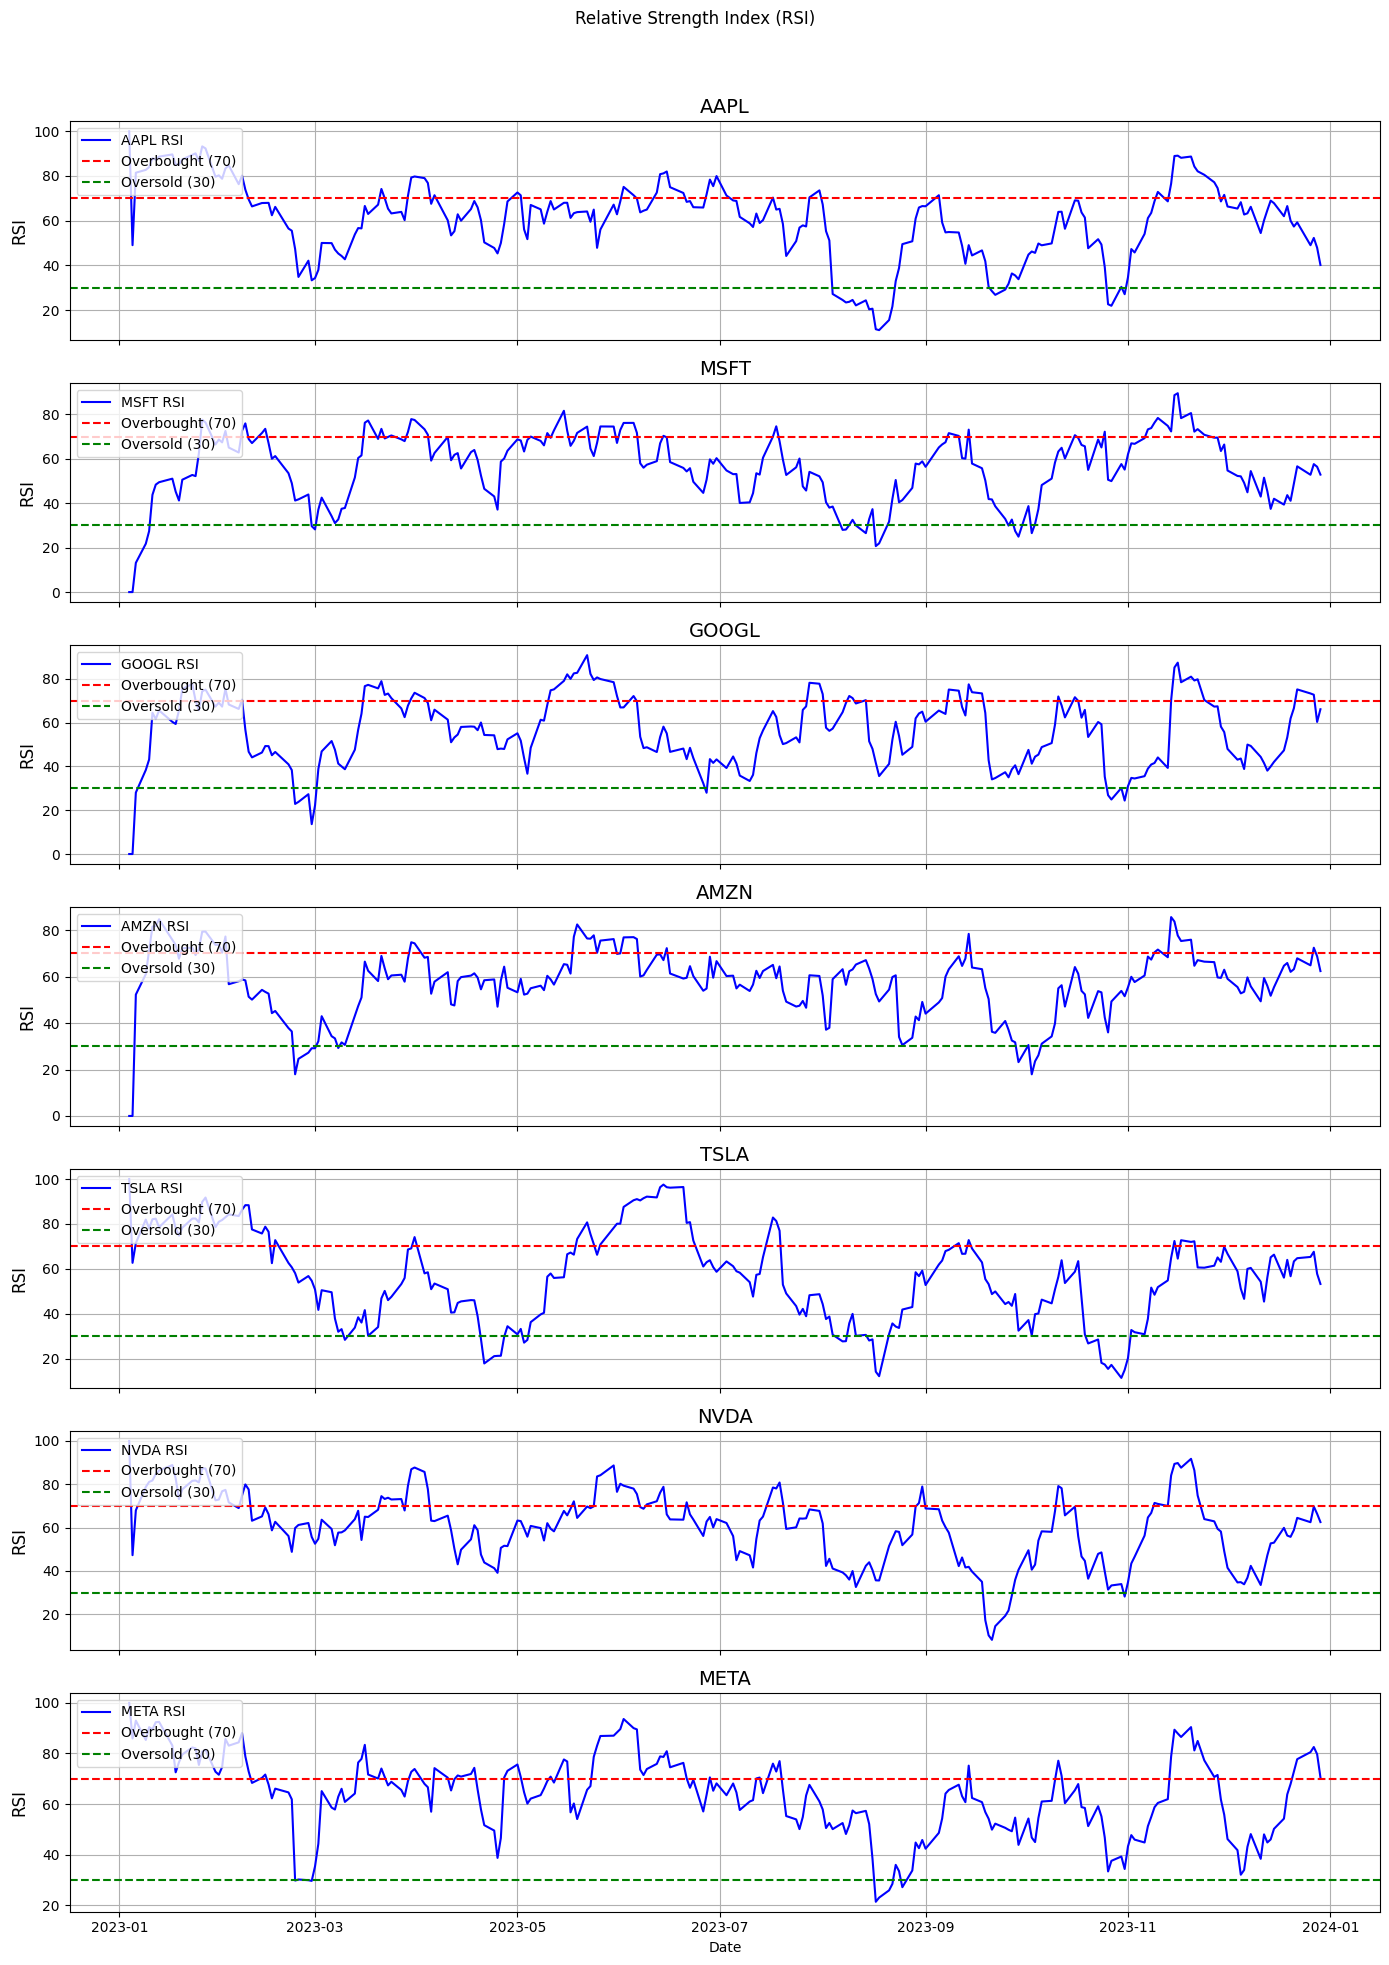

In [25]:
def calculate_stock_rsi(tickers, period=14, start_date='2023-01-01', end_date='2024-01-01'):
    rsi_dict = {}
    
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            stock_data['Change'] = stock_data['Close'].diff()
            stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
            stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)

            stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
            stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

            stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
            stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

            rsi_dict[ticker] = stock_data[['Close', 'RSI']].dropna()
            
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating RSI")
            rsi_dict[ticker] = None
    
    return rsi_dict

def plot_stock_rsi(tickers, start='2023-01-01', end='2024-01-01', period=14):
    rsi_dict = calculate_stock_rsi(tickers, period, start, end)

    valid_rsi = {ticker: data for ticker, data in rsi_dict.items() if data is not None}

    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Relative Strength Index (RSI)')

    for ax, (ticker, data) in zip(axes, valid_rsi.items()):
        ax.plot(data.index, data['RSI'], label=f'{ticker} RSI', color='blue')
        ax.axhline(70, color='red', linestyle='--', label='Overbought (70)')
        ax.axhline(30, color='green', linestyle='--', label='Oversold (30)')
        ax.set_title(ticker, fontsize=14)
        ax.set_ylabel('RSI', fontsize=12)
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_stock_rsi(tickers, start='2023-01-01', end='2024-01-01')

#### Stock Price Strength

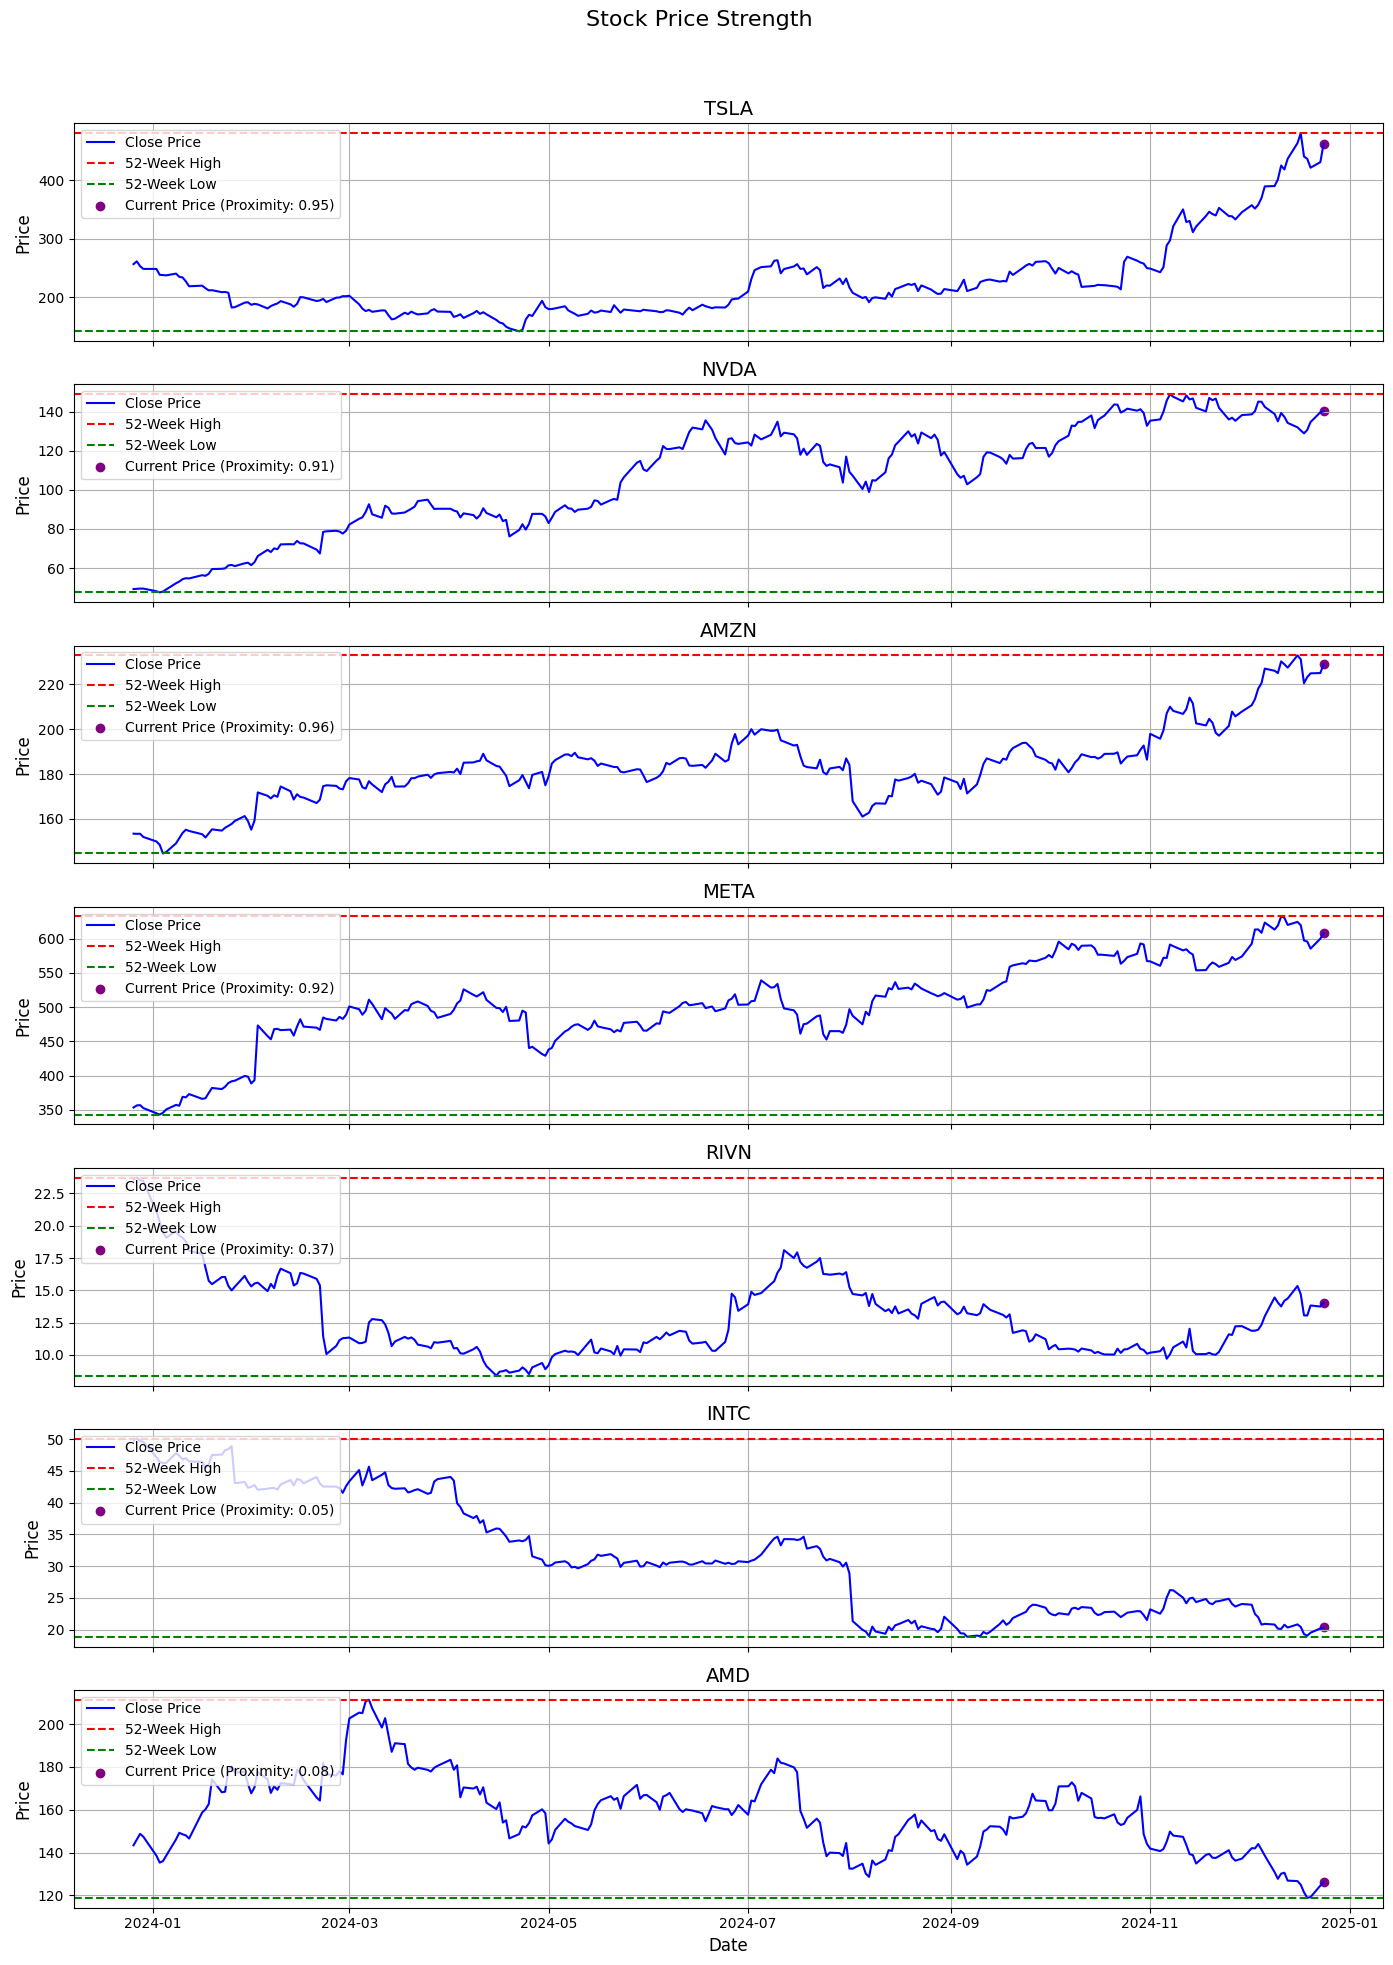

In [47]:
def calculate_stock_price_strength(ticker):
    try:
        stock_data = yf.Ticker(ticker)
        prior_year_history = stock_data.history(period="1y")

        high = prior_year_history['Close'].max()
        low = prior_year_history['Close'].min()
        current_price = prior_year_history['Close'].iloc[-1]
        proximity_to_high = (current_price - low) / (high - low)

        return high, low, current_price, proximity_to_high, prior_year_history
    except Exception as error:
        print(f"An error occurred for {ticker}: {error}")
        return None, None, None, None, None

def plot_stock_price_strength(tickers):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Stock Price Strength', fontsize=16)

    if len(tickers) == 1:
        axes = [axes]

    for ax, ticker in zip(axes, tickers):
        high, low, current_price, proximity_to_high, prior_year_history = calculate_stock_price_strength(ticker)

        if prior_year_history is not None:
            ax.plot(prior_year_history.index, prior_year_history['Close'], label='Close Price', color='blue')
            ax.axhline(high, color='red', linestyle='--', label='52-Week High')
            ax.axhline(low, color='green', linestyle='--', label='52-Week Low')
            ax.scatter(prior_year_history.index[-1], current_price, color='purple',
                       label=f'Current Price (Proximity: {proximity_to_high:.2f})')

            ax.set_title(ticker, fontsize=14)
            ax.set_ylabel('Price', fontsize=12)
            ax.legend(loc='upper left')
            ax.grid(True)
        else:
            ax.set_title(f"{ticker} (Error)", fontsize=14)
            ax.text(0.5, 0.5, "Error: Unable to fetch data", transform=ax.transAxes,
                    fontsize=12, color='red', ha='center', va='center')
            ax.axis('off')

    axes[-1].set_xlabel('Date', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_stock_price_strength(tickers)

#### Stock Price Breadth

In [58]:
def calculate_stock_price_breadth(tickers, start, end):
    all_results = pd.DataFrame()

    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start, end=end)
            close_data = data['Close']
            volume_data = data['Volume']

            price_change = close_data.pct_change().fillna(0)
            results = pd.DataFrame(index=close_data.index)

            results['rising_volume'] = np.where(price_change > 0, volume_data, 0)
            results['declining_volume'] = np.where(price_change < 0, volume_data, 0)

            results['breadth_ratio'] = results['rising_volume'].sum() / results['declining_volume'].sum()
            results['ticker'] = ticker

            all_results = pd.concat([all_results, results])
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating price breadth")

    return all_results

def plot_stock_price_breadth(tickers: list):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Stock Price Breadth')

    for ax, ticker in zip(axes, tickers):
        breadth_data = calculate_stock_price_breadth(ticker, start=start_date, end=end_date)
        
        ax.plot(breadth_data.index, breadth_data['breadth_ratio'], label=ticker)
        ax.axhline(1, color='red', linestyle='--', label='Neutral (1)')
        ax.set_title(ticker)
        ax.set_ylabel('Breadth Ratio')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

calculate_stock_price_breadth(tickers)
plot_stock_price_breadth(tickers)

#### Market Volatility

In [ ]:
def calculate_market_volatility(tickers, start_date=start_date, end_date=start_date):
    volatility_dict = {}
    
    for ticker in tickers:
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            stock_data['Returns'] = stock_data['Close'].pct_change()
            stock_data['Volatility'] = stock_data['Returns'].rolling(window=50).std() * np.sqrt(252)
            
            latest_volatility = stock_data['Volatility'].iloc[-1]
            volatility_dict[ticker] = latest_volatility
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating volatility")
            volatility_dict[ticker] = None
    
    return volatility_dict

def plot_market_volatility(tickers):
    volatility_data = calculate_market_volatility(tickers, start_date, end_date)
    
    plt.figure(figsize=(10, 6))
    for ticker in tickers:
        plt.plot(volatility_data[ticker], label=ticker)
    
    plt.title('Market Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()

calculate_market_volatility(tickers)
plot_market_volatility(tickers)


#### Put-Call Ratio

In [48]:
def calculate_put_call_ratio(tickers):
    put_call_ratios = {}
    
    for ticker in tickers:
        try:
            options = yf.Ticker(ticker).option_chain()
            puts = options.puts
            calls = options.calls
            
            total_put_volume = puts['volume'].sum()
            total_call_volume = calls['volume'].sum()
            put_call_ratio = total_put_volume / total_call_volume if total_call_volume != 0 else None
            put_call_ratios[ticker] = put_call_ratio
            
        except Exception as error:
            print(f"An error occurred for {ticker}: {error} when calculating put call ratio")
            put_call_ratios[ticker] = None
    
    return put_call_ratios

def plot_put_call_ratio(tickers: list):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Put Call Ratio')

    for ax, ticker in zip(axes, tickers):
        put_call_data = calculate_put_call_ratio([ticker])
        ax.plot(put_call_data[ticker].index, put_call_data[ticker], label=ticker)
        ax.axhline(1, color='red', linestyle='--', label='Neutral (1)')
        ax.set_title(ticker)
        ax.set_ylabel('Put Call Ratio')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    calculate_put_call_ratio(tickers)
    plot_put_call_ratio(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [49]:
fear_greed_scores = get_fear_greed(tickers, start_date, end_date)
print(fear_greed_scores)

{'TSLA': 0.5544536466712165, 'NVDA': 0.555328682471397, 'AMZN': 0.5139187856722055, 'META': 0.5624216471109679, 'RIVN': 0.39361131142703665, 'INTC': 0.3474219622687874, 'AMD': 0.38864173774683874}


### Convert to Views

In [33]:
bullish_threshold = 0.50 # this should ideally be 70+
bearish_threshold = 0.3

fg_based_views = {}
fg_based_confidences = {}

for ticker, score in fear_greed_scores.items():
    if score > bullish_threshold:
        view_returns = 0.02 + (score - bullish_threshold) * 0.0001
    elif score < bearish_threshold:
        view_returns = -0.02 + (bearish_threshold - score) * 0.0001
    else:
        view_returns = 0.0

    fg_based_views[ticker] = view_returns
    confidence = abs(score - 0.5) / 0.5
    fg_based_confidences[ticker] = confidence

fg_views_array = np.array([value for value in fg_based_views.values() if value != 0.0])
fg_confidences_array = np.array([value for value in fg_based_confidences.values() if value != 0.0])

print(f"Views: {fg_views_array}")
print(f"Confidences: {fg_confidences_array}")

Views: [0.02000545 0.02000553 0.02000139 0.02000624]
Confidences: [0.10890729 0.11065736 0.02783757 0.12484329 0.21277738 0.30515607
 0.22271652]


In [34]:
# views per ticker {'TSLA': 0.020004905972819897, 'NVDA': 0.020001646317597807, 'AMZN': 0.02000531466844215, 'META': 0.02000369495348263, 'RIVN': 0.0, 'INTC': 0.0, 'AMD': 0.0}
# tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

picking_matrix = np.array([ # picking matrix needs to be relative for each ticker (outperforming vs underperforming)
    [1, 0, 0, 0, 0, 0, 0],  # TSLA
    [0, 1, 0, 0, 0, 0, 0],  # NVDA
    [0, 0, 1, 0, 0, 0, 0],  # AMZN
    [0, 0, 0, 1, 0, 0, 0],  # META
])

fear_greed_bl = BlackLittermanModel(
    fg_covariance_matrix, 
    pi=prior,
    absolute_views=None,
    Q=fg_views_array,
    P=picking_matrix,
    omega="idzorek",
    view_confidences=fg_confidences_array,
    tau=0.025,
    risk_aversion=delta
)

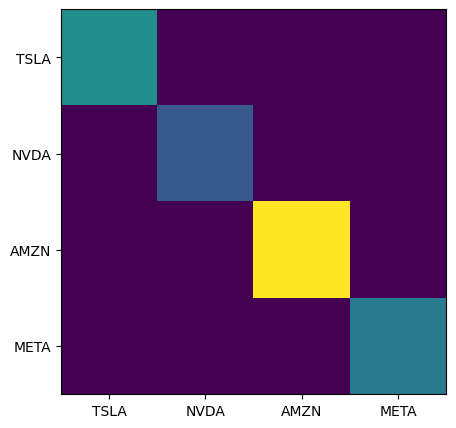

In [35]:
def plot_omega():
    tickers_with_views = ["TSLA", "NVDA", "AMZN", "META"]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(fear_greed_bl.omega)

    ax.set_xticks(np.arange(len(tickers_with_views)))
    ax.set_yticks(np.arange(len(tickers_with_views)))

    ax.set_xticklabels(tickers_with_views)
    ax.set_yticklabels(tickers_with_views)
    plt.show()

    np.diag(fear_greed_bl.omega)

plot_omega()

In [36]:
fear_greed_returns = fear_greed_bl.bl_returns()
fear_greed_returns

Ticker
AMD     0.022448
AMZN    0.021849
INTC    0.021182
META    0.022072
NVDA    0.022963
RIVN    0.022689
TSLA    0.022608
dtype: float64

In [37]:
views_vs_scores = pd.DataFrame([fear_greed_scores, fg_based_views, fg_based_confidences], index=["Fear-Greed Scores", "Views", "Confidences"]).T
views_vs_scores

,Fear-Greed Scores,Views,Confidences
TSLA,0.554454,0.020005,0.108907
NVDA,0.555329,0.020006,0.110657
AMZN,0.513919,0.020001,0.027838
META,0.562422,0.020006,0.124843
RIVN,0.393611,0.000000,0.212777
INTC,0.347422,0.000000,0.305156
AMD,0.388642,0.000000,0.222717


<Axes: >

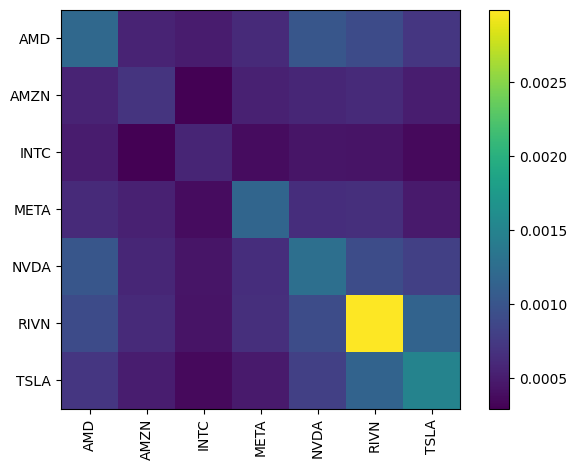

In [38]:
fg_posterior_cov = fear_greed_bl.bl_cov()
plotting.plot_covariance(fg_posterior_cov)

In [39]:
fg_ef = EfficientFrontier(fear_greed_returns, fg_posterior_cov)
min_vol_weights = fg_ef.min_volatility()
# max_sharpe_weights = fg_ef.max_sharpe() # max_sharpe not working. look into this

cleaned_weights = fg_ef.clean_weights()
cleaned_weights

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.37619),
             ('INTC', 0.57157),
             ('META', 0.01552),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.03672)])

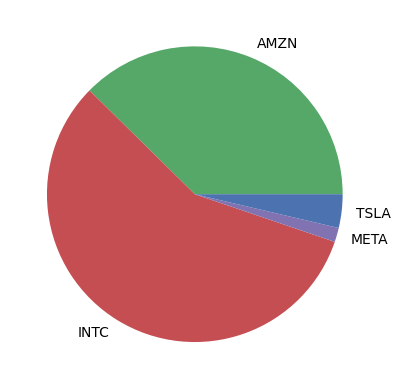

In [40]:
model_2_allocations = pd.Series(cleaned_weights).plot.pie()

In [41]:
fg_ef.portfolio_performance(verbose=True)

Expected annual return: 2.1%
Annual volatility: 2.1%
Sharpe Ratio: 0.07


(0.021498751266142733, 0.021385426631676224, 0.07008283219951164)

In [42]:
latest_prices = get_latest_prices(data)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

ValueError: Cannot broadcast dimensions  (7,) (42,)